# 🔴 **Import Libs**

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import v2

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
# import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


# 🔴 **Arguments**

In [ ]:
seed = 8

batch_size = 8

train_path = "/content/v0.3/processed/train"
valid_path = "/content/v0.3/processed/test"

train_ann = "/content/v0.3/processed/train/metadata.csv"
valid_ann = "/content/v0.3/processed/test/metadata.csv"

color2number = {
    "blue": 0,
    "brown": 1,
    "red": 2,
    "yellow": 3,
    "green": 4
}

number2color = {
    0: "blue",
    1: "brown",
    2: "red",
    3: "yellow",
    4: "green"
}

epochs = 100

gf_dim = 64
df_dim = 64

L1_lambda = 100.0

in_w = in_h = 256
in_dim = 5
out_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔴 **Dataset**

## 🟠 Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/CVDatasets/coloring_dataset-v0.3.zip /content/

In [ ]:
!unzip /content/coloring_dataset-v0.3.zip

Archive:  /content/coloring_dataset-v0.3.zip
  inflating: v0.3/dataset-preparation.ipynb  
   creating: v0.3/processed/
   creating: v0.3/processed/test/
   creating: v0.3/processed/test/inputs/
  inflating: v0.3/processed/test/inputs/0001.bmp  
  inflating: v0.3/processed/test/inputs/0002.bmp  
  inflating: v0.3/processed/test/inputs/0003.bmp  
  inflating: v0.3/processed/test/inputs/0004.bmp  
  inflating: v0.3/processed/test/metadata.csv  
   creating: v0.3/processed/test/targets/
  inflating: v0.3/processed/test/targets/0001.bmp  
  inflating: v0.3/processed/test/targets/0002.bmp  
  inflating: v0.3/processed/test/targets/0003.bmp  
  inflating: v0.3/processed/test/targets/0004.bmp  
  inflating: v0.3/processed/test/targets/0005.bmp  
  inflating: v0.3/processed/test/targets/0006.bmp  
  inflating: v0.3/processed/test/targets/0007.bmp  
  inflating: v0.3/processed/test/targets/0008.bmp  
  inflating: v0.3/processed/test/targets/0009.bmp  
  inflating: v0.3/processed/test/targets/00

In [ ]:
!rm /content/coloring_dataset-v0.3.zip

## 🟠 EDA

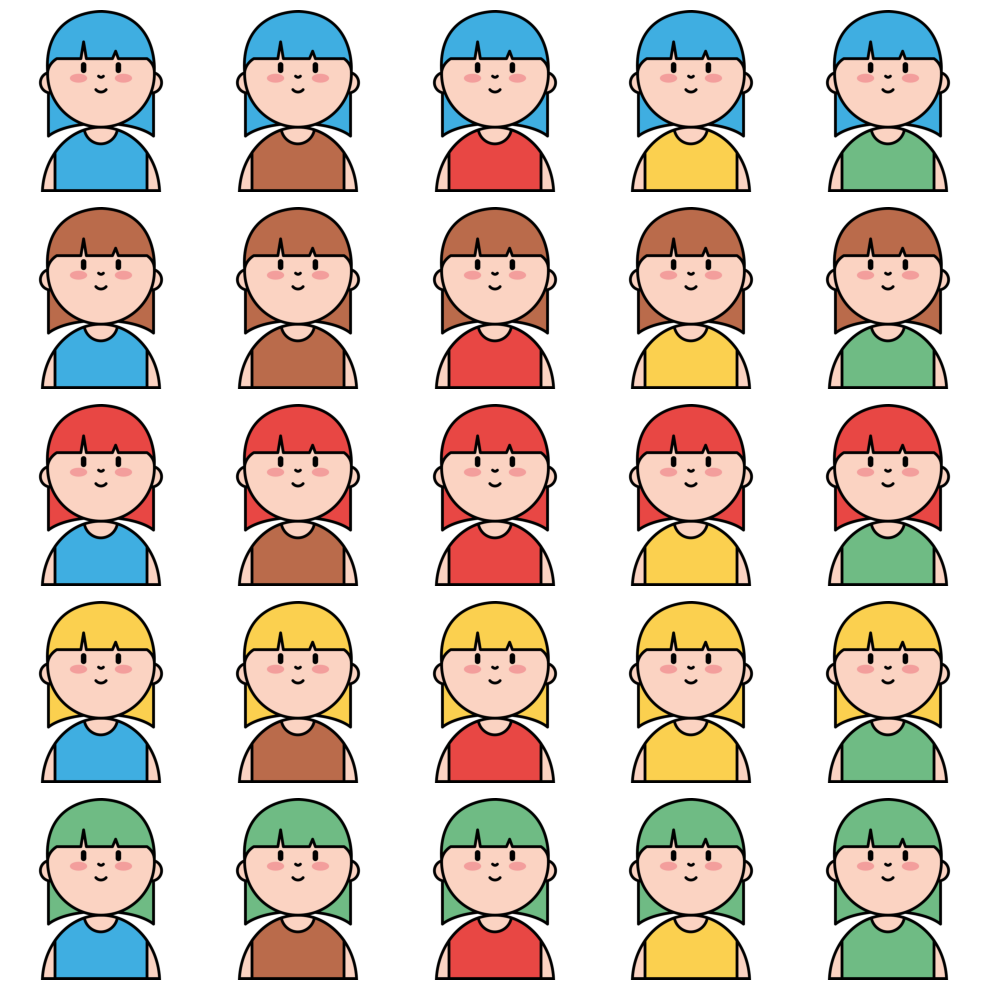

In [ ]:
id = np.random.randint(0, 10, 1)[0]

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    img = Image.open(os.path.join(train_path, f'targets/{str(id * 25 + i + 1).zfill(4)}.bmp'))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


## 🟠 Custom dataset

In [ ]:
class GANset(Dataset):
  def __init__(self, data_path, data_ann, transforms):
    self.data = pd.read_csv(data_ann)
    self.data_path = data_path
    self.transforms = transforms

  def __getitem__(self, idx):
    input = tv_tensors.Image(Image.open(os.path.join(self.data_path, "inputs", self.data.iloc[idx]["input"])))
    target = tv_tensors.Image(Image.open(os.path.join(self.data_path, "targets", self.data.iloc[idx]["target"])))
    hair = color2number[self.data.iloc[idx]["hair"]]
    shirt = color2number[self.data.iloc[idx]["shirt"]]

    if self.transforms:
      input, target = self.transforms(input, target)

    hair_color = torch.full_like(input[0], hair).unsqueeze(0)
    shirt_color = torch.full_like(input[0], shirt).unsqueeze(0)

    return input, target, hair_color, shirt_color

  def __len__(self):
    return len(self.data)


In [ ]:
train_transform = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

valid_transform = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
trainset = GANset(train_path, train_ann, train_transform)
validset = GANset(valid_path, valid_ann, valid_transform)

trainset[24][0].shape, trainset[24][1].shape, trainset[24][2].shape, trainset[24][3].shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]))

In [ ]:
x = torch.randint(0, len(trainset), (1,))[0].item()
image = torchvision.transforms.functional.to_pil_image(trainset[x][0])
target = torchvision.transforms.functional.to_pil_image(trainset[x][1])

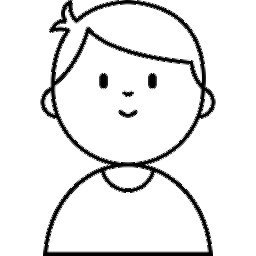

In [ ]:
image

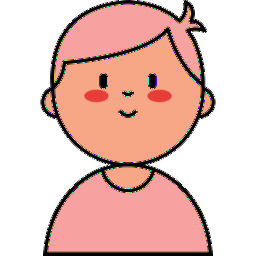

In [ ]:
target

## 🟠 Define a dataloader

In [ ]:
trainloader = DataLoader(trainset, batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size, shuffle=False)

In [ ]:
data = next(iter(trainloader))
data[0].shape, data[1].shape, data[2].shape, data[3].shape

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 3, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]))

# 🔴 **Model**

In [ ]:
def cnn_block(in_channels, out_channels, kernel_size, stride=1,
              padding=0, first_layer = False):

   if first_layer:
       return nn.Conv2d(in_channels, out_channels, kernel_size,
                        stride=stride, padding=padding)

   else:
       return nn.Sequential(
           nn.Conv2d(in_channels, out_channels, kernel_size,
                     stride=stride,padding=padding),
           nn.BatchNorm2d(out_channels, momentum=0.1, eps=1e-5),
           )

def tcnn_block(in_channels, out_channels, kernel_size, stride=1, padding=0,
               output_padding=0, first_layer = False):

   if first_layer:
       return nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                 stride=stride, padding=padding,
                                 output_padding=output_padding)

   else:
       return nn.Sequential(
           nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding,
                              output_padding=output_padding),
           nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
           )

In [ ]:
class Generator(nn.Module):
 def __init__(self, instance_norm=False):
   super(Generator,self).__init__()
   self.e1 = cnn_block(in_dim, gf_dim, 4, 2, 1, first_layer = True)
   self.e2 = cnn_block(gf_dim, gf_dim*2, 4, 2, 1,)
   self.e3 = cnn_block(gf_dim*2,gf_dim*4, 4, 2, 1,)
   self.e4 = cnn_block(gf_dim*4, gf_dim*8, 4, 2, 1,)
   self.e5 = cnn_block(gf_dim*8, gf_dim*8, 4, 2, 1,)
   self.e6 = cnn_block(gf_dim*8, gf_dim*8, 4, 2, 1,)
   self.e7 = cnn_block(gf_dim*8, gf_dim*8, 4, 2, 1,)
   self.e8 = cnn_block(gf_dim*8, gf_dim*8, 4, 2, 1, first_layer=True)

   self.d1 = tcnn_block(gf_dim*8, gf_dim*8, 4, 2, 1)
   self.d2 = tcnn_block(gf_dim*8*2, gf_dim*8, 4, 2, 1)
   self.d3 = tcnn_block(gf_dim*8*2, gf_dim*8, 4, 2, 1)
   self.d4 = tcnn_block(gf_dim*8*2, gf_dim*8, 4, 2, 1)
   self.d5 = tcnn_block(gf_dim*8*2, gf_dim*4,4, 2, 1)
   self.d6 = tcnn_block(gf_dim*4*2, gf_dim*2,4, 2, 1)
   self.d7 = tcnn_block(gf_dim*2*2, gf_dim*1,4, 2, 1)
   self.d8 = tcnn_block(gf_dim*1*2, out_dim,4, 2, 1, first_layer = True)#256x256
   self.tanh = nn.Tanh()

 def forward(self, x):
   e1 = self.e1(x)
   e2 = self.e2(F.leaky_relu(e1,0.2))
   e3 = self.e3(F.leaky_relu(e2,0.2))
   e4 = self.e4(F.leaky_relu(e3,0.2))
   e5 = self.e5(F.leaky_relu(e4,0.2))
   e6 = self.e6(F.leaky_relu(e5,0.2))
   e7 = self.e7(F.leaky_relu(e6,0.2))
   e8 = self.e8(F.leaky_relu(e7,0.2))
   d1 = torch.cat([F.dropout(self.d1(F.relu(e8)), 0.5, training=True), e7], 1)
   d2 = torch.cat([F.dropout(self.d2(F.relu(d1)), 0.5, training=True), e6], 1)
   d3 = torch.cat([F.dropout(self.d3(F.relu(d2)), 0.5, training=True), e5], 1)
   d4 = torch.cat([self.d4(F.relu(d3)), e4], 1)
   d5 = torch.cat([self.d5(F.relu(d4)), e3], 1)
   d6 = torch.cat([self.d6(F.relu(d5)), e2], 1)
   d7 = torch.cat([self.d7(F.relu(d6)), e1], 1)
   d8 = self.d8(F.relu(d7))

   return self.tanh(d8)

In [ ]:
class Discriminator(nn.Module):
 def __init__(self, instance_norm=False):#input : 256x256
   super(Discriminator,self).__init__()
   self.conv1 = cnn_block(in_dim*2, df_dim, 4, 2, 1, first_layer=True) # 128x128
   self.conv2 = cnn_block(df_dim, df_dim*2, 4, 2, 1)                  # 64x64
   self.conv3 = cnn_block(df_dim*2, df_dim*4, 4, 2, 1)                # 32x32
   self.conv4 = cnn_block(df_dim*4, df_dim*8, 4, 1, 1)                # 31x31
   self.conv5 = cnn_block(df_dim*8, 1, 4, 1, 1, first_layer=True)     # 30x30

   self.sigmoid = nn.Sigmoid()
 def forward(self, x, y):
   O = torch.cat([x, y], dim=1)
   O = F.leaky_relu(self.conv1(O),0.2)
   O = F.leaky_relu(self.conv2(O),0.2)
   O = F.leaky_relu(self.conv3(O),0.2)
   O = F.leaky_relu(self.conv4(O),0.2)
   O = self.conv5(O)

   return self.sigmoid(O)

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

# 🔴 **Config**

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()
L1_loss = nn.L1Loss()

# 🔴 **Train ➰**

In [ ]:
def train_one_epoch(generator, discriminator, train_loader, G_optimizer, D_optimizer, epoch=None):
  G.train()
  D.train()
  G_loss_train = AverageMeter()
  D_loss_train = AverageMeter()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets, hair, shirt in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      hair = hair.to(device)
      shirt = shirt.to(device)

      #Train discriminator
      discriminator.zero_grad()

      inputs = torch.cat([hair, shirt, inputs], 1)

      outputs = generator(inputs)

      new_outputs = torch.cat([hair, shirt, outputs], 1)
      new_targets = torch.cat([hair, shirt, targets], 1)

      generated_labels = discriminator(new_outputs, inputs)
      true_labels = discriminator(new_targets, inputs)

      real_classes = torch.ones(len(true_labels), 1, 30, 30).to(device)
      fake_classes = torch.zeros(len(true_labels), 1, 30, 30).to(device)

      real_gan_loss = bce_loss(true_labels, real_classes)
      fake_gan_loss = bce_loss(generated_labels, fake_classes)

      D_loss = real_gan_loss + fake_gan_loss
      D_loss.backward()
      D_optimizer.step()

      D_loss_train.update(D_loss.item(), n=len(targets))

      #Train generator
      generator.zero_grad()

      outputs = generator(inputs)

      new_outputs = torch.cat([hair, shirt, outputs], 1)

      generated_labels = discriminator(new_outputs, inputs)
      g_label_loss = bce_loss(generated_labels, real_classes)

      l1loss = L1_loss(targets, outputs)

      G_loss = g_label_loss + L1_lambda*l1loss
      G_loss.backward()
      G_optimizer.step()

      G_loss_train.update(G_loss.item(), n=len(targets))


  return D, G, D_loss_train.avg, G_loss_train.avg

# 🔴 **Evaluation**

In [ ]:
def evaluate(test_loader, generator, discriminator):
  G.eval()
  D.eval()
  G_loss_eval = AverageMeter()
  D_loss_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets, hair, shirt in test_loader:

      inputs = inputs.to(device)
      targets = targets.to(device)
      hair = hair.to(device)
      shirt = shirt.to(device)

      #discriminator eval
      inputs = torch.cat([hair, shirt, inputs], 1)

      outputs = generator(inputs)

      new_outputs = torch.cat([hair, shirt, outputs], 1)
      new_targets = torch.cat([hair, shirt, targets], 1)

      generated_labels = discriminator(new_outputs, inputs)
      true_labels = discriminator(new_targets, inputs)

      real_classes = torch.ones(len(true_labels), 1, 30, 30).to(device)
      fake_classes = torch.zeros(len(true_labels), 1, 30, 30).to(device)

      real_gan_loss = bce_loss(true_labels, real_classes)
      fake_gan_loss = bce_loss(generated_labels, fake_classes)

      D_loss = real_gan_loss + fake_gan_loss
      D_loss_eval.update(D_loss.item(), n=len(targets))

      #generator eval
      g_label_loss = bce_loss(generated_labels, real_classes)

      l1loss = L1_loss(targets, outputs)

      G_loss = g_label_loss + L1_lambda*l1loss
      G_loss_eval.update(G_loss.item(), n=len(targets))

  return D_loss_eval.avg, G_loss_eval.avg

# 🔴 **Training Process 〽️**

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define train dataloader.

In [ ]:
set_seed(seed)
train_loader = DataLoader(trainset, batch_size, shuffle=True)
valid_loader = DataLoader(validset, batch_size, shuffle=False)

🔰 Define model.

In [ ]:
set_seed(seed)
G = Generator().to(device)
D = Discriminator().to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
G_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
G_loss_train_hist = []
G_loss_valid_hist = []

D_loss_train_hist = []
D_loss_valid_hist = []

best_G_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = epochs

for epoch in range(num_epochs):
  # Train
  D, G, D_loss_train, G_loss_train = train_one_epoch(G, D, train_loader, G_optimizer, D_optimizer, epoch)

  # Validation
  D_loss_valid, G_loss_valid = evaluate(valid_loader, G, D)

  D_loss_train_hist.append(D_loss_train)
  D_loss_valid_hist.append(D_loss_valid)

  G_loss_train_hist.append(G_loss_train)
  G_loss_valid_hist.append(G_loss_valid)

  if G_loss_valid < best_G_loss_valid:
    torch.save(G, f'G_model.pt')
    torch.save(D, f'D_model.pt')
    best_G_loss_valid = G_loss_valid
    print('Model Saved!')

  print(f'Valid: Generator Loss = {G_loss_valid:.4}, Discriminator Loss = {D_loss_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Model Saved!
Valid: Generator Loss = 22.36, Discriminator Loss = 2.17



Epoch 1: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Model Saved!
Valid: Generator Loss = 15.45, Discriminator Loss = 1.562



Epoch 2: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Model Saved!
Valid: Generator Loss = 13.96, Discriminator Loss = 1.749



Epoch 3: 100%|██████████| 32/32 [00:18<00:00,  1.76batch/s]


Model Saved!
Valid: Generator Loss = 12.41, Discriminator Loss = 1.647



Epoch 4: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 17.26, Discriminator Loss = 2.996



Epoch 5: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 12.57, Discriminator Loss = 2.463



Epoch 6: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 17.62, Discriminator Loss = 1.676



Epoch 7: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Model Saved!
Valid: Generator Loss = 10.66, Discriminator Loss = 1.541



Epoch 8: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 9.162, Discriminator Loss = 1.388



Epoch 9: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 9.68, Discriminator Loss = 1.757



Epoch 10: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 12.28, Discriminator Loss = 1.513



Epoch 11: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 15.61, Discriminator Loss = 1.589



Epoch 12: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 9.763, Discriminator Loss = 1.562



Epoch 13: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 8.507, Discriminator Loss = 1.458



Epoch 14: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 9.585, Discriminator Loss = 1.489



Epoch 15: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 9.25, Discriminator Loss = 1.578



Epoch 16: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 10.77, Discriminator Loss = 1.433



Epoch 17: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 7.812, Discriminator Loss = 1.674



Epoch 18: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 8.606, Discriminator Loss = 1.519



Epoch 19: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 9.052, Discriminator Loss = 1.437



Epoch 20: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 7.344, Discriminator Loss = 1.497



Epoch 21: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 10.75, Discriminator Loss = 1.714



Epoch 22: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 9.77, Discriminator Loss = 1.59



Epoch 23: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 9.05, Discriminator Loss = 1.671



Epoch 24: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 8.008, Discriminator Loss = 1.743



Epoch 25: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 8.175, Discriminator Loss = 1.58



Epoch 26: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 8.604, Discriminator Loss = 2.922



Epoch 27: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Model Saved!
Valid: Generator Loss = 7.141, Discriminator Loss = 1.571



Epoch 28: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 7.759, Discriminator Loss = 1.45



Epoch 29: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 6.276, Discriminator Loss = 1.453



Epoch 30: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 7.495, Discriminator Loss = 1.361



Epoch 31: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.669, Discriminator Loss = 1.68



Epoch 32: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 7.594, Discriminator Loss = 1.619



Epoch 33: 100%|██████████| 32/32 [00:18<00:00,  1.76batch/s]


Valid: Generator Loss = 7.291, Discriminator Loss = 1.572



Epoch 34: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 10.09, Discriminator Loss = 1.746



Epoch 35: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.835, Discriminator Loss = 1.59



Epoch 36: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.848, Discriminator Loss = 2.134



Epoch 37: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 7.751, Discriminator Loss = 1.882



Epoch 38: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 6.248, Discriminator Loss = 1.413



Epoch 39: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 6.271, Discriminator Loss = 1.385



Epoch 40: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 5.606, Discriminator Loss = 1.385



Epoch 41: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Model Saved!
Valid: Generator Loss = 5.399, Discriminator Loss = 1.397



Epoch 42: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 5.394, Discriminator Loss = 1.389



Epoch 43: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.483, Discriminator Loss = 1.394



Epoch 44: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Model Saved!
Valid: Generator Loss = 5.357, Discriminator Loss = 1.395



Epoch 45: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.834, Discriminator Loss = 1.384



Epoch 46: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 6.773, Discriminator Loss = 1.394



Epoch 47: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.789, Discriminator Loss = 1.384



Epoch 48: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 7.368, Discriminator Loss = 1.391



Epoch 49: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.487, Discriminator Loss = 1.351



Epoch 50: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 5.277, Discriminator Loss = 1.424



Epoch 51: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.36, Discriminator Loss = 1.394



Epoch 52: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.753, Discriminator Loss = 1.419



Epoch 53: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.498, Discriminator Loss = 1.4



Epoch 54: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.21, Discriminator Loss = 1.427



Epoch 55: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.311, Discriminator Loss = 1.511



Epoch 56: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.644, Discriminator Loss = 1.654



Epoch 57: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Model Saved!
Valid: Generator Loss = 5.02, Discriminator Loss = 1.581



Epoch 58: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.898, Discriminator Loss = 1.548



Epoch 59: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.524, Discriminator Loss = 1.546



Epoch 60: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.592, Discriminator Loss = 1.606



Epoch 61: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.111, Discriminator Loss = 1.438



Epoch 62: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 6.696, Discriminator Loss = 1.482



Epoch 63: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.038, Discriminator Loss = 1.504



Epoch 64: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 8.508, Discriminator Loss = 1.769



Epoch 65: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.604, Discriminator Loss = 1.507



Epoch 66: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 6.219, Discriminator Loss = 1.547



Epoch 67: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 5.505, Discriminator Loss = 1.525



Epoch 68: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 8.358, Discriminator Loss = 1.699



Epoch 69: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 7.113, Discriminator Loss = 1.462



Epoch 70: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.287, Discriminator Loss = 1.478



Epoch 71: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 5.642, Discriminator Loss = 1.451



Epoch 72: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.088, Discriminator Loss = 1.619



Epoch 73: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 9.8, Discriminator Loss = 1.552



Epoch 74: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.164, Discriminator Loss = 1.429



Epoch 75: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 8.029, Discriminator Loss = 1.452



Epoch 76: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.661, Discriminator Loss = 1.795



Epoch 77: 100%|██████████| 32/32 [00:18<00:00,  1.76batch/s]


Valid: Generator Loss = 6.842, Discriminator Loss = 1.805



Epoch 78: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.578, Discriminator Loss = 1.583



Epoch 79: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.712, Discriminator Loss = 1.47



Epoch 80: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 7.422, Discriminator Loss = 2.343



Epoch 81: 100%|██████████| 32/32 [00:18<00:00,  1.76batch/s]


Valid: Generator Loss = 7.388, Discriminator Loss = 1.782



Epoch 82: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 7.028, Discriminator Loss = 1.939



Epoch 83: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 6.231, Discriminator Loss = 1.526



Epoch 84: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 7.045, Discriminator Loss = 1.623



Epoch 85: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 5.627, Discriminator Loss = 1.509



Epoch 86: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.689, Discriminator Loss = 1.472



Epoch 87: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 5.6, Discriminator Loss = 1.49



Epoch 88: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Valid: Generator Loss = 5.561, Discriminator Loss = 1.615



Epoch 89: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Model Saved!
Valid: Generator Loss = 5.016, Discriminator Loss = 1.483



Epoch 90: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 5.148, Discriminator Loss = 1.457



Epoch 91: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Model Saved!
Valid: Generator Loss = 4.715, Discriminator Loss = 1.396



Epoch 92: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Model Saved!
Valid: Generator Loss = 4.667, Discriminator Loss = 1.368



Epoch 93: 100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]


Model Saved!
Valid: Generator Loss = 4.541, Discriminator Loss = 1.382



Epoch 94: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Valid: Generator Loss = 5.148, Discriminator Loss = 1.389



Epoch 95: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 4.617, Discriminator Loss = 1.371



Epoch 96: 100%|██████████| 32/32 [00:18<00:00,  1.72batch/s]


Model Saved!
Valid: Generator Loss = 4.525, Discriminator Loss = 1.395



Epoch 97: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 5.856, Discriminator Loss = 1.513



Epoch 98: 100%|██████████| 32/32 [00:18<00:00,  1.74batch/s]


Valid: Generator Loss = 6.524, Discriminator Loss = 1.462



Epoch 99: 100%|██████████| 32/32 [00:18<00:00,  1.73batch/s]


Valid: Generator Loss = 5.03, Discriminator Loss = 1.38



In [ ]:
model = torch.load("/content/G_model.pt")

<ipython-input-46-032cff6d230a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/G_model.pt")


## 🟠 Plot

🔰 Plot learning curves

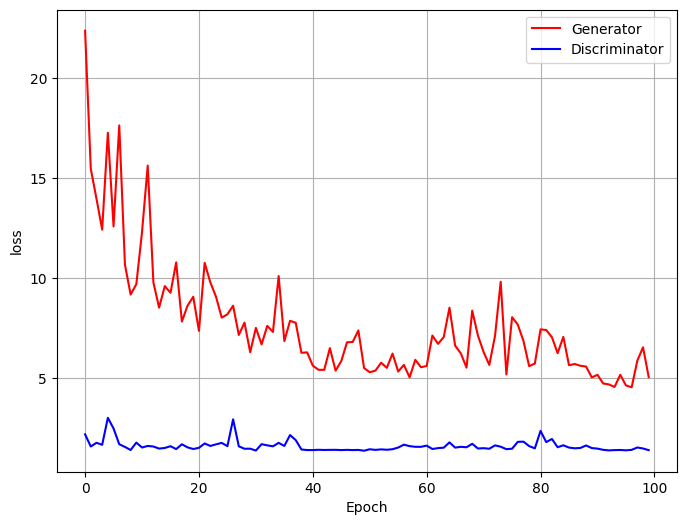

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), G_loss_valid_hist, 'r-', label='Generator')
plt.plot(range(epoch_counter), D_loss_valid_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

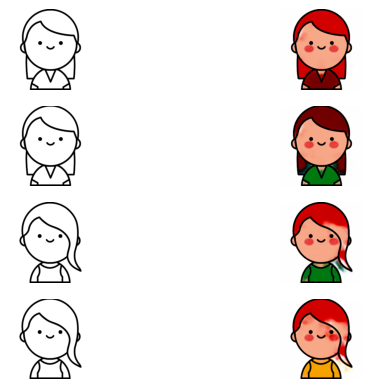

In [ ]:
fig, axes = plt.subplots(4, 2)
for i in range(4):
  idx = random.randint(0, len(validset) - 1)

  inputs = validset[idx][0].to(device)
  targets = validset[idx][1].to(device)
  hair = validset[idx][2].to(device)
  shirt = validset[idx][3].to(device)

  new_inputs = torch.cat([hair, shirt, inputs])

  outputs = model(new_inputs.unsqueeze(0))

  # print(f"hair: {number2color[hair[0][0][0].item()]}, shirt: {number2color[shirt[0][0][0].item()]}")

  axes[i][0].imshow(inputs.cpu().permute(1, 2, 0)), axes[i][0].axis('off');
  axes[i][1].imshow(outputs[0].cpu().permute(1, 2, 0).detach().numpy()), axes[i][1].axis('off');